# Autoencoder as FE for Binary Classification

In [184]:
%matplotlib inline

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU, Input, BatchNormalization

### Autoencoder

In [185]:
diabetes = pd.read_csv('Diabetes2021/diabetes_binary_5050split_health_indicators_BRFSS2021.csv')
# diabetes = pd.read_csv('Diabetes2021/diabetes_binary_health_indicators_BRFSS2021.csv')
# X_test = diabetes_test.drop(columns=['Diabetes_binary', 'NoDocbcCost', 'MentHlth', 'Sex', 'Fruits'])
# Y_test = diabetes_test['Diabetes_binary']


X = diabetes.loc[:, ['GenHlth', 'DiffWalk', 'PhysHlth']]
# X = diabetes.drop(columns=['Diabetes_binary', 'NoDocbcCost', 'MentHlth', 'Sex', 'Fruits'])
Y = diabetes['Diabetes_binary']

X = X.values
Y = Y.values

In [186]:
# x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=1)
# x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=2)

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=2)

# scale data
t = StandardScaler()
t.fit(x_train)
x_train = t.transform(x_train)
x_test = t.transform(x_test)
x_val = t.transform(x_val)

In [187]:
from keras.layers import Dropout
from keras.regularizers import l2

# n_inputs = 17
n_inputs = 3

# define encoder
visible = Input(shape=(n_inputs,))

# encoder level 1
e = Dense(round(float(n_inputs*1.5)))(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# e = Dropout(0.2)(e)

# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# e = Dropout(0.2)(e)

# # encoder level 3
# e = Dense(round(float(n_inputs) / 2))(e)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)

# bottleneck
n_bottleneck = round(float(n_inputs) / 3)
bottleneck = Dense(n_bottleneck)(e)

In [188]:
# define decoder, level 1
d = Dense(round(float(n_inputs)))(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# d = Dropout(0.2)(d)

# # decoder level 2
# d = Dense(n_inputs)(d)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# decoder level 3
d = Dense(round(float(n_inputs*1.5)))(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# # d = Dropout(0.2)(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [189]:
model.summary()

Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 4)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_82 (LeakyReLU)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 3)              │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_83 (LeakyReLU)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_85 (LeakyReLU)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102 (408.00 B)

 Trainable params: 80 (320.00 B)

 Non-trainable params: 22 (88.00 B)

In [190]:
from keras.optimizers import Adam
 
optimizer = Adam(learning_rate=0.001)

# compile autoencoder model
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

In [191]:
# fit the autoencoder model to reconstruct input
history = model.fit(x_train, x_train, epochs=50, batch_size=32, verbose=2, validation_data=(x_val,x_val))

Epoch 1/50
1469/1469 - 1s - 978us/step - accuracy: 0.5331 - loss: 0.3901 - val_accuracy: 0.3502 - val_loss: 0.2863
Epoch 2/50
1469/1469 - 1s - 455us/step - accuracy: 0.6764 - loss: 0.3124 - val_accuracy: 0.8027 - val_loss: 0.2609
Epoch 3/50
1469/1469 - 1s - 458us/step - accuracy: 0.7987 - loss: 0.2985 - val_accuracy: 0.9310 - val_loss: 0.2546
Epoch 4/50
1469/1469 - 1s - 497us/step - accuracy: 0.8410 - loss: 0.2910 - val_accuracy: 0.9270 - val_loss: 0.2417
Epoch 5/50
1469/1469 - 1s - 495us/step - accuracy: 0.8530 - loss: 0.2808 - val_accuracy: 0.9209 - val_loss: 0.2325
Epoch 6/50
1469/1469 - 1s - 456us/step - accuracy: 0.8598 - loss: 0.2731 - val_accuracy: 0.5492 - val_loss: 0.2375
Epoch 7/50
1469/1469 - 1s - 455us/step - accuracy: 0.8671 - loss: 0.2632 - val_accuracy: 0.9474 - val_loss: 0.2168
Epoch 8/50
1469/1469 - 1s - 454us/step - accuracy: 0.8654 - loss: 0.2556 - val_accuracy: 0.9429 - val_loss: 0.2042
Epoch 9/50
1469/1469 - 1s - 457us/step - accuracy: 0.8655 - loss: 0.2489 - val_a

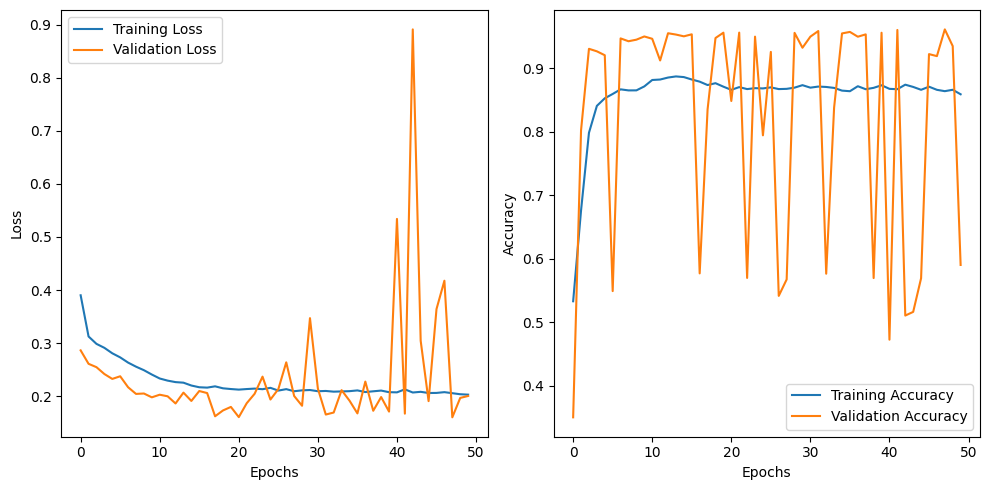

In [193]:
# plot loss
# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.savefig('AE_loss_acc_separate.png')
plt.show()

In [156]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)

# # save the encoder to file
# encoder.save('encoder.keras')
# encoder = load_model('encoder.keras')

# encode the train data
x_train_encode = encoder.predict(x_train)

# encode the test data
x_test_encode = encoder.predict(x_test)

# encode the val data
x_val_encode = encoder.predict(x_val)

1469/1469 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# define AE_model
AE_model = LogisticRegression()

# fit AE_model on training set
AE_model.fit(x_train_encode, y_train)

# make prediction on test set
yhat = AE_model.predict(x_test_encode)

# calculate accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.6507794657928706


## NN

In [99]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from keras.layers import Activation
from tensorflow.keras.metrics import Recall


# creating neural net
nn_model = Sequential()
nn_model.add(Input(shape=(6,)))
nn_model.add(Dense(14, activation = 'relu'))
nn_model.add(Dense(5, activation = 'relu'))
nn_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.01, beta_1=0.9)

nn_model.compile(optimizer=optimizer,
              loss='BinaryCrossentropy',
              metrics=['accuracy', Recall()])


In [100]:
nn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_89 (Dense)                │ (None, 14)             │            98 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 5)              │            75 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179 (716.00 B)

 Trainable params: 179 (716.00 B)

 Non-trainable params: 0 (0.00 B)

In [101]:
# fit the model to the training data
history = nn_model.fit(x_train_encode, y_train, epochs=25, batch_size=16, validation_data=(x_val_encode, y_val))

Epoch 1/25
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 2s 359us/step - accuracy: 0.7095 - loss: 0.5596 - recall_1: 0.7555 - val_accuracy: 0.7213 - val_loss: 0.5415 - val_recall_1: 0.8424
Epoch 2/25
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 330us/step - accuracy: 0.7290 - loss: 0.5378 - recall_1: 0.8019 - val_accuracy: 0.7293 - val_loss: 0.5408 - val_recall_1: 0.7818
Epoch 3/25
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 331us/step - accuracy: 0.7271 - loss: 0.5361 - recall_1: 0.7920 - val_accuracy: 0.7310 - val_loss: 0.5318 - val_recall_1: 0.7977
Epoch 4/25
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 331us/step - accuracy: 0.7281 - loss: 0.5375 - recall_1: 0.7982 - val_accuracy: 0.7310 - val_loss: 0.5308 - val_recall_1: 0.7846
Epoch 5/25
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 346us/step - accuracy: 0.7304 - loss: 0.5338 - recall_1: 0.7989 - val_accuracy: 0.7318 - val_loss: 0.5368 - val_recall_1: 0.7500
Epoch 6/25
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 331us/step - accuracy: 0.7286 - loss: 0.5350 - recall_1: 0.8076 - val_accuracy: 0.732

In [104]:
# evaluate the model on the test dataset
score = nn_model.evaluate(x_test_encode, y_test, batch_size=100)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])
print("Test Recall:", score[2])

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - accuracy: 0.7343 - loss: 0.5313 - recall_1: 0.7585
Test Loss: 0.5264604091644287
Test Accuracy: 0.7368917465209961
Test Recall: 0.7590270042419434


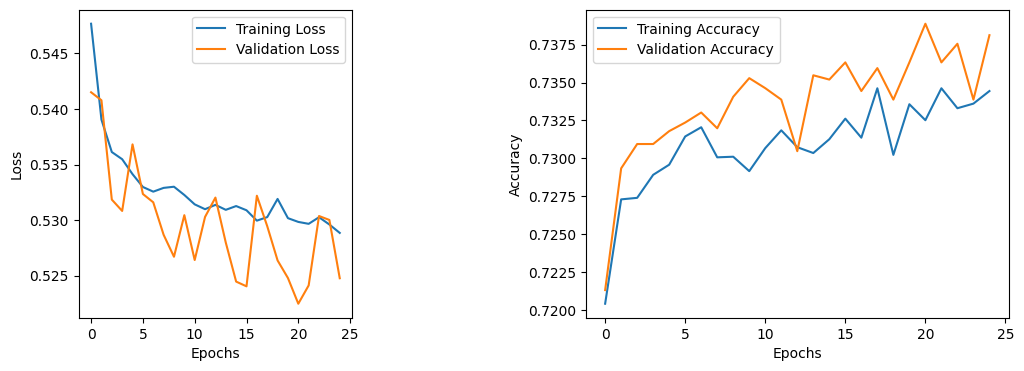

In [109]:
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
# training_recall = history.history['recall']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']
# validation_recall = history.history['val_recall']

# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('AEFE - loss.png')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('AEFE - accuracy.png')
plt.legend()


In [110]:
# Predict on test data
y_pred = nn_model.predict(x_test_encode)
y_pred_classes = np.round(y_pred)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
Confusion Matrix:
[[3820 1522]
 [1268 3994]]


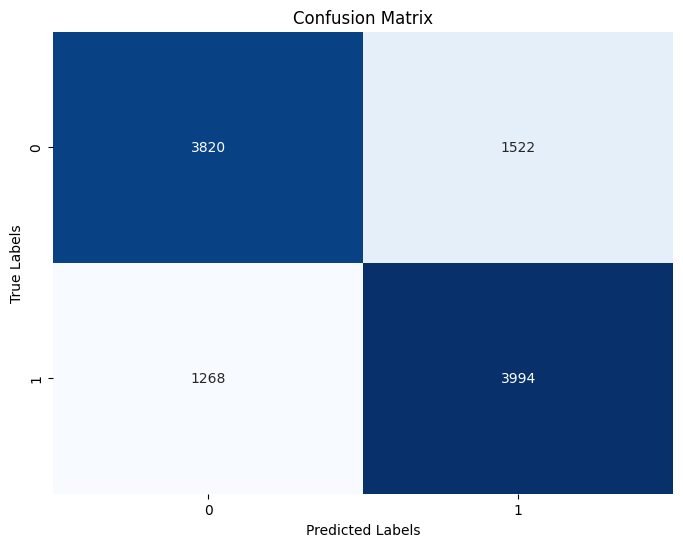

In [112]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('AEFE - CM.png')
plt.show()

## NN Custom Callback

In [113]:
from keras.callbacks import Callback
from keras import backend as K

class AdjustLearningRateOnRecall(Callback):
    def __init__(self, monitor='val_recall', factor=0.5, patience=3, min_lr=1e-6):
        super(AdjustLearningRateOnRecall, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.best_recall = -1
        self.wait = 0
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_recall = logs.get(self.monitor)
        if current_recall is None:
            return

        if current_recall > self.best_recall:
            self.best_recall = current_recall
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Epoch %d: Early stopping due to no improvement in recall" % (epoch + 1))

        lr = float(K.get_value(self.model.optimizer.lr))
        if lr > self.min_lr and self.wait >= self.patience:
            new_lr = lr * self.factor
            new_lr = max(new_lr, self.min_lr)
            K.set_value(self.model.optimizer.lr, new_lr)
            print("Epoch %d: Adjusting learning rate to %f" % (epoch + 1, new_lr))

# Usage example:
# adjust_lr_callback = AdjustLearningRateOnRecall()
# model.fit(X_train, y_train, callbacks=[adjust_lr_callback])


In [115]:
# creating neural net
nncc = Sequential()
nncc.add(Input(shape=(6,)))
nncc.add(Dense(14, activation = 'relu'))
nncc.add(Dense(5, activation = 'relu'))
nncc.add(Dense(1, activation='sigmoid'))

adjust_lr_callback = AdjustLearningRateOnRecall()

optimizer = Adam(learning_rate=0.01, beta_1=0.9)

nncc.compile(optimizer=optimizer,
              loss='BinaryCrossentropy',
              metrics=['accuracy', Recall()])


In [116]:
callbacks=[adjust_lr_callback]
# fit the model to the training data
history = nn_model.fit(x_train_encode, y_train, epochs=50, batch_size=16, validation_data=(x_val_encode, y_val), callbacks=[adjust_lr_callback])

Epoch 1/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 337us/step - accuracy: 0.7328 - loss: 0.5304 - recall_1: 0.7862 - val_accuracy: 0.7355 - val_loss: 0.5262 - val_recall_1: 0.7812
Epoch 2/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 328us/step - accuracy: 0.7306 - loss: 0.5344 - recall_1: 0.7805 - val_accuracy: 0.7378 - val_loss: 0.5235 - val_recall_1: 0.8125
Epoch 3/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 334us/step - accuracy: 0.7369 - loss: 0.5267 - recall_1: 0.7924 - val_accuracy: 0.7314 - val_loss: 0.5298 - val_recall_1: 0.8142
Epoch 4/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 343us/step - accuracy: 0.7303 - loss: 0.5339 - recall_1: 0.7951 - val_accuracy: 0.7373 - val_loss: 0.5273 - val_recall_1: 0.7706
Epoch 5/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 336us/step - accuracy: 0.7354 - loss: 0.5322 - recall_1: 0.7926 - val_accuracy: 0.7380 - val_loss: 0.5247 - val_recall_1: 0.7709
Epoch 6/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 330us/step - accuracy: 0.7298 - loss: 0.5332 - recall_1: 0.7803 - val_accuracy: 0.730

In [119]:
# evaluate the model on the test dataset
nccscore = nncc.evaluate(x_test_encode, y_test, batch_size=16)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])
print("Test Recall:", score[2])

663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - accuracy: 0.6144 - loss: 0.6446 - recall_3: 0.3693
Test Loss: 0.5264604091644287
Test Accuracy: 0.7368917465209961
Test Recall: 0.7590270042419434


7928/7928 ━━━━━━━━━━━━━━━━━━━━ 1s 186us/step
Confusion Matrix:
[[218203    131]
 [ 35280     66]]


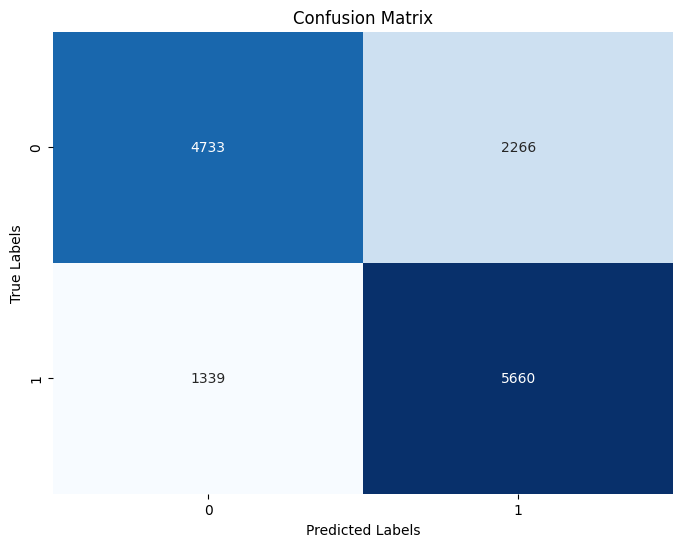

In [207]:
# Predict on test data
y_pred = nncc.predict(X_test_encode)
y_pred_classes = np.round(y_pred)

# Calculate confusion matrix
nncc_cm = confusion_matrix(Y_test, y_pred_classes)
print("Confusion Matrix:")
print(nncc_cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## NN FE

In [120]:
# add new classifier layers

from keras.regularizers import l2
class1 = Dense(10, activation='relu', kernel_regularizer=l2(0.001))(encoder.layers[-1].output)
class2 = Dense(5, activation='relu')(class1)
output = Dense(1, activation='sigmoid')(class2)

nn_encoder = Model(inputs=encoder.inputs, outputs=output)

print(nn_encoder.summary())

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 26)             │           468 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 26)             │           104 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_54 (LeakyReLU)      │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 17)             │           459 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 17)             │            68 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_55 (LeakyReLU)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 6)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,338 (5.23 KB)

 Trainable params: 1,252 (4.89 KB)

 Non-trainable params: 86 (344.00 B)

None


In [121]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.losses import BinaryCrossentropy


for layer in nn_encoder.layers[:-3]:
    layer.trainable = False

optimizer = Adam(learning_rate=0.001, beta_1=0.9)
# optimizer = RMSprop(learning_rate=0.001, momentum=0.9)
# optimizer = Adagrad(learning_rate=0.001)
# optimizer = "Adam"
nn_encoder.compile(optimizer=optimizer, loss="BinaryCrossentropy", metrics=['accuracy', Recall()])

nn_encoder.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step - accuracy: 0.6394 - loss: 0.6349 - recall_4: 0.6797 - val_accuracy: 0.7212 - val_loss: 0.5531 - val_recall_4: 0.7643
Epoch 2/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step - accuracy: 0.7244 - loss: 0.5495 - recall_4: 0.7605 - val_accuracy: 0.7233 - val_loss: 0.5481 - val_recall_4: 0.7708
Epoch 3/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 380us/step - accuracy: 0.7269 - loss: 0.5442 - recall_4: 0.7660 - val_accuracy: 0.7280 - val_loss: 0.5443 - val_recall_4: 0.7474
Epoch 4/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step - accuracy: 0.7269 - loss: 0.5431 - recall_4: 0.7662 - val_accuracy: 0.7272 - val_loss: 0.5420 - val_recall_4: 0.7659
Epoch 5/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - accuracy: 0.7246 - loss: 0.5416 - recall_4: 0.7664 - val_accuracy: 0.7279 - val_loss: 0.5414 - val_recall_4: 0.7218
Epoch 6/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - accuracy: 0.7314 - loss: 0.5369 - recall_4: 0.7728 - val_accuracy: 0.729

In [123]:
y_pred = nn_encoder.predict(x_test)

# evaluate the model on the test dataset
nn_score = nn_model.evaluate(x_test_encode, y_test)
print("Test Loss:", nn_score[0])
print("Test Accuracy:", nn_score[1])
print("Test Recall:", nn_score[2])

332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - accuracy: 0.7283 - loss: 0.5389 - recall_1: 0.7652
Test Loss: 0.5335016250610352
Test Accuracy: 0.7333081960678101
Test Recall: 0.7666286826133728
